In [52]:
import sys
sys.path.append('..')


from scipy.signal import resample
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from modeling import Code2EEG, Match
import matplotlib.pyplot as plt
import os
import pandas as pd
import utils

In [53]:
srate = 250
refreshrate = 60
poolSize = 100

testSize = 40  #select n classes of data as test data
tmin,tmax = 0,0.5
n_band = 1
p=0.96
blockNUM=6
winLENs = [1]
winLEN = 1
lag = 0
pools = np.logspace(1, 4, num=20).astype(int)

chnNames = ['PZ','PO5', 'POZ', 'PO3','PO4', 'PO6', 'O1', 'OZ','O2']
saveFILE = 'largeset.csv'

In [54]:
# %%
# load data
expName = 'sweep'
dir = '../datasets/%s.pickle' % expName
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

In [55]:
i=3
sub = wholeset[i]

chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']

sub['name']

'miaoyining'

In [56]:
X_ = np.stack(X[y == i] for i in np.unique(y))
y_ = np.stack(y[y == i] for i in np.unique(y))

# split conditions
X_train, X_test, y_train, y_test = train_test_split(X_, y_,test_size=testSize,random_state=253)

X_train,X_test = np.concatenate(X_train, axis=0), np.concatenate(X_test, axis=0)
y_train,y_test = np.concatenate(y_train, axis=0), np.concatenate(y_test, axis=0)
S_train,S_test = np.stack([S[i-1] for i in y_train]),np.stack([S[i-1] for i in y_test])

/Users/shinanlin/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


The goal: get TRF and spatial filter

In [58]:
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=p,padding=True,n_band=n_band,component=1)
code2EEG.fit(X_train,y_train)

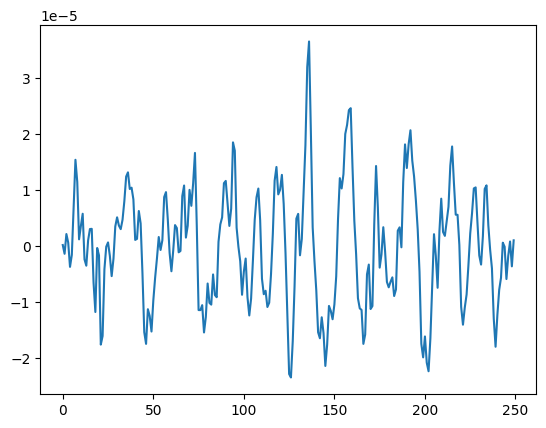

In [66]:
plt.plot(X_[0].T)

In [65]:
# X_ 是原本真实数据
X_ = code2EEG.enhancer.transform(X_test)
_class_subset = np.unique(y_test)
n = len(np.unique(y_test))

# S_test = np.stack(S_test[y_test == i].mean(axis=0) for i in _class_subset)
# X_ = np.concatenate([X_[y_test==i] for i in _class_subset])

In [50]:
X_[y_test==_class_subset[0]].shape

(6, 1, 250)

In [40]:
np.random.seed(2)
# re-create massive loads of STI patterns
buildSTI = np.random.uniform(0, 1, (int(poolSize), int(winLEN*refreshrate)))
# upsample
buildSTI = resample(buildSTI,num=int(winLEN*srate),axis=-1)

In [42]:
templates = np.concatenate((S_test, buildSTI), axis=0)
_classes = np.arange(start=0,stop=len(templates),step=1,dtype='int')
y_test = np.repeat(_classes[:n],repeats=blockNUM)

In [59]:
templates = code2EEG.predict(S=templates)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [45]:
model = Match(srate=srate, winLEN=0.8, lag=lag)
model.fit(templates, _classes)
accuracy = model.score(X_, y_test)

In [46]:
accuracy

0.0